In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation

from sklearn.model_selection import train_test_split

print("Done!")


2024-07-01 13:28:16.257800: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 13:28:16.534296: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 13:28:17.521461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 13:28:19.728150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Done!


In [2]:
"""display function"""
def display_n_plots_format2(t_axis,data,n,m,wave_2=None, c=1, Mode=0):
    print("--------------------------------------------------------")

    if Mode!=0:

        for i in range(n):
            exec(f'SecondWave{i+1}=np.array([])')
        for i in range(100):
            for j in range(n):
                exec(f'SecondWave{j+1}=np.append(SecondWave{j+1}, wave_2[{m}][{i}][{j}])')
        SecondWaves=[]
        for i in range(n):
            exec (f'SecondWaves.append(SecondWave{i+1})')

    for i in range(n):
        exec(f'Channel{i+1}=np.array([])')
    for i in range(100):
        for j in range(n):
            exec(f'Channel{j+1}=np.append(Channel{j+1}, data[{m}][{i}][{j}])')
    Channels=[]
    for i in range(n):
        exec (f'Channels.append(Channel{i+1})')



    fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # Adjust the figure size
    y_limits = (-250, 250)
    for i, ax in enumerate(axs.flat):
        ax.plot(t_axis, c * Channels[i])

        if Mode!=0:
            ax.plot(t_axis, c * SecondWaves[i])

        ax.set_title(f'Channel {i + 1}', fontsize=10)

        ax.set_ylim(y_limits)
        ax.grid(True, lw=0.5)
        ax.label_outer()  # Only show outer labels to avoid redundancy


    fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title
    #plt.savefig(f'Figure {int(t_axis[-1] //200)+1} w 16 Controlled channels')
    plt.show()

print("Done!")

Done!


In [3]:
training_data=pd.read_pickle("training_data_High_Amplitude.pkl")
real_data=pd.read_pickle("real_data_High_Amplitude.pkl")

noisy_test=pd.read_pickle("Test_data_High_Amplitude.pkl")
real_test=pd.read_pickle("Test_real_High_Amplitude.pkl")

print("Done!")

Done!


In [4]:
Params= 128,1000,16
Params1=192,1000,16
def remove_time_transpose_reshape(set,params):
    set=set.drop(columns=['t_axis'])
    #set=set.transpose()
    set=set.values
    return set.reshape(params[0], params[1], params[2])

In [5]:
""" reshapes the data st it can fit in the CNN """
#print(type(training_data))
N_Train_Data=remove_time_transpose_reshape(training_data,Params)
C_Train_Real=remove_time_transpose_reshape(real_data,Params)
N_Test_Data=remove_time_transpose_reshape(noisy_test,Params1)
C_Test_Real=remove_time_transpose_reshape(real_test,Params1)


/tmp/ipykernel_26560/3962982779.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  set=set.drop(columns=['t_axis'])


NameError: name 't_axis' is not defined

--------------------------------------------------------


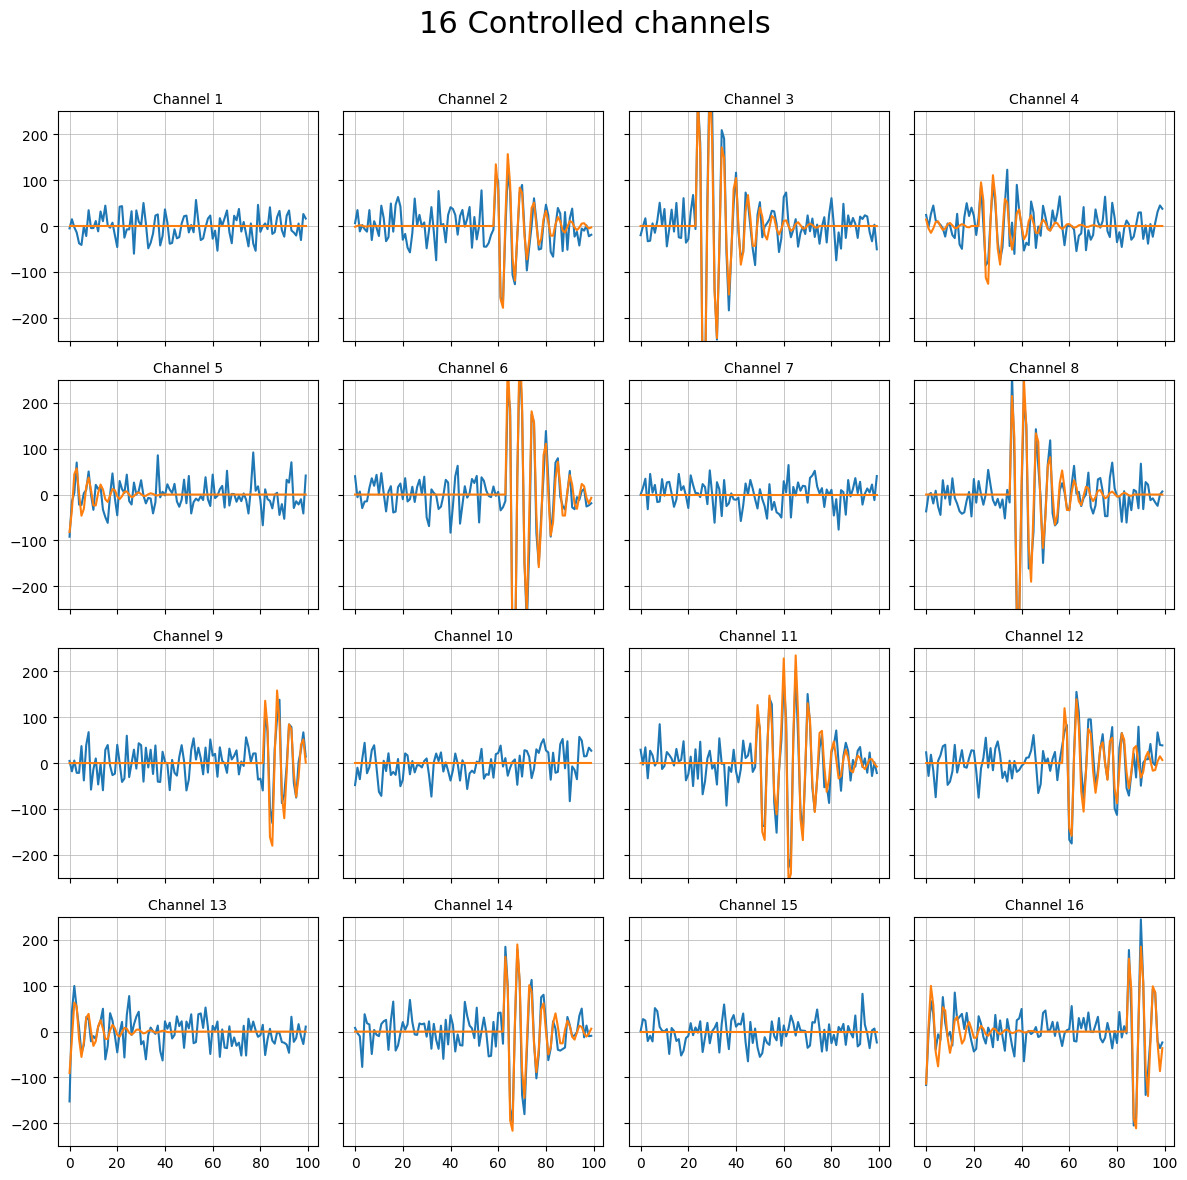

In [7]:
t_axis=np.arange(0,100,1)
display_n_plots_format2(t_axis,N_Train_Data,16,5,C_Train_Real,1,1)
#display_n_plots_format2(t_axis,C_Train_Real,16,0)

In [20]:
"""normalize to go from -1 to 1"""
maxes=[]
maxes.append(np.max(np.abs(N_Train_Data)))
maxes.append(np.max(np.abs(C_Train_Real)))
maxes.append(np.max(np.abs(N_Test_Data)))
maxes.append(np.max(np.abs(C_Test_Real)))
max=np.max(maxes)
N_Train_Data=N_Train_Data/max
C_Train_Real=C_Train_Real/max
N_Test_Data=N_Test_Data/max
C_Test_Real=C_Test_Real/max

input_shape=np.shape(N_Train_Data)
print(input_shape)


(128, 1000, 16)


In [26]:
def build_denoising_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(1000, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Decoder
    model.add(layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(1000, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



In [27]:
model

<Sequential name=sequential, built=True>

In [33]:
# Example input shape: (time_steps, 16)

# Build and compile the model
model = build_denoising_model((1000,16))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 1000, 128)      │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 500, 1000)      │       385,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 250, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 250, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 125, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 125, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 250, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 250, 1000)      │        49,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 500, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 500, 128)       │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_8 (UpSampling1D)  │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 1000, 16)       │         6,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 879,360 (3.35 MB)

 Trainable params: 879,360 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:



# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(N_Train_Data, C_Train_Real, test_size=0.3, random_state=42)
print(np.shape(X_train), np.shape(X_val))
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val))

(89, 1000, 16) (39, 1000, 16)
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9m

In [35]:
def build_denoising_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    # Decoder
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.UpSampling1D(size=2))
    model.add(layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Example input shape: (time_steps, 16)
input_shape = (None, 16)  # None for variable time steps

# Build and compile the model
model = build_denoising_model(input_shape)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, None, 64)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_9 (UpSampling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, None, 16)       │         3,088 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,576 (72.56 KB)

 Trainable params: 18,576 (72.56 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:

# Train the model
model.fit(N_Train_Data,C_Train_Real , epochs=25, batch_size=1, validation_split=0.2)
model.save("CNN_model_2_mightkeep.keras")
print("Done!")


Epoch 1/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 2/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 7/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 11/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 12/25
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [39]:
# Step 4: Evaluate and Visualize the Results
# Generate clean and noisy test waveforms
NC_Trained_Test = model.predict(N_Test_Data)
NC_Trained_Original= model.predict( N_Train_Data)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


--------------------------------------------------------


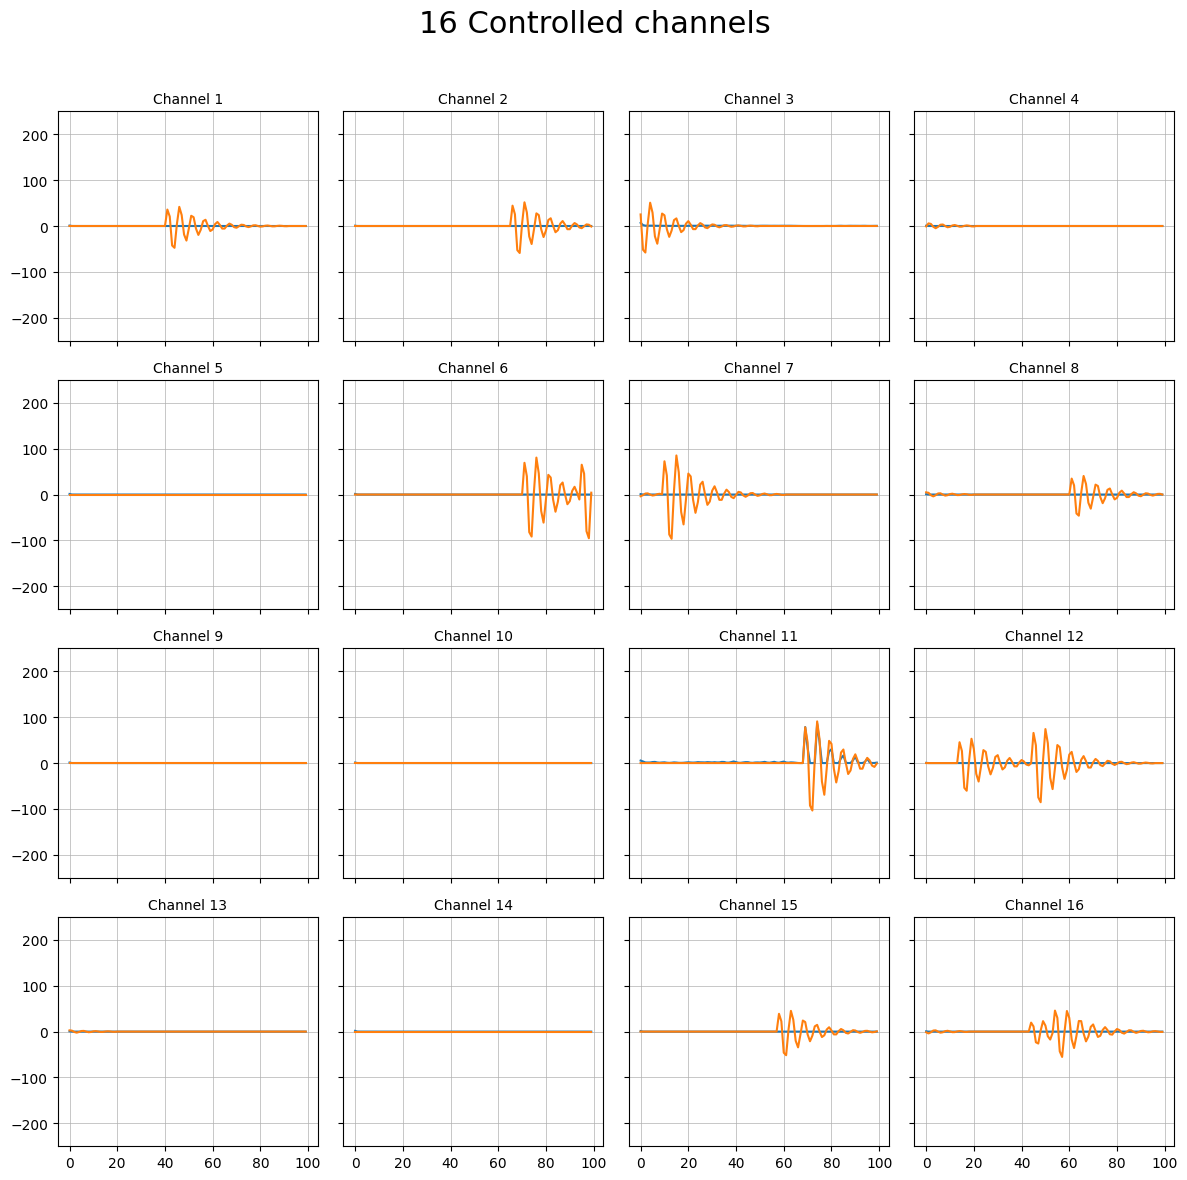

In [44]:
display_n_plots_format2(t_axis,NC_Trained_Test,16,9,C_Test_Real,200,1)